In [68]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [65]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [70]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape) # N=batch size, C=channels, H=height, W=width
    print("Shape of y: ", y.shape, y.dtype)
    break

test_dataloader

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


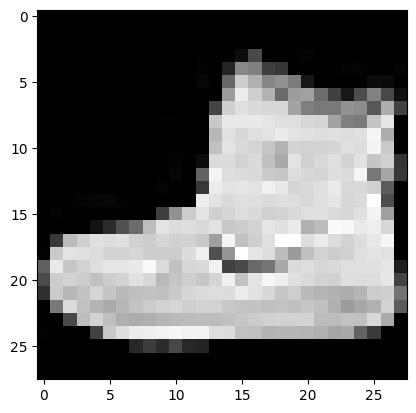

Label: 9


In [71]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

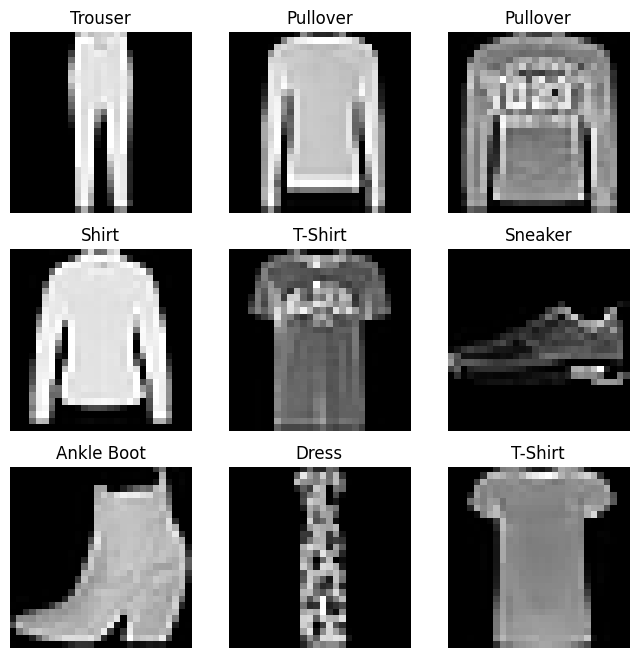

In [69]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            lable = self.target_transform(label)
        return image, label

In [72]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [15]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # [64, 1, 28, 28] -> [64, 1*28*28]
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [21]:
for batch, (X, y) in enumerate(train_dataloader):

    print(batch, X.shape, y.shape)

0 torch.Size([64, 1, 28, 28]) torch.Size([64])
1 torch.Size([64, 1, 28, 28]) torch.Size([64])
2 torch.Size([64, 1, 28, 28]) torch.Size([64])
3 torch.Size([64, 1, 28, 28]) torch.Size([64])
4 torch.Size([64, 1, 28, 28]) torch.Size([64])
5 torch.Size([64, 1, 28, 28]) torch.Size([64])
6 torch.Size([64, 1, 28, 28]) torch.Size([64])
7 torch.Size([64, 1, 28, 28]) torch.Size([64])
8 torch.Size([64, 1, 28, 28]) torch.Size([64])
9 torch.Size([64, 1, 28, 28]) torch.Size([64])
10 torch.Size([64, 1, 28, 28]) torch.Size([64])
11 torch.Size([64, 1, 28, 28]) torch.Size([64])
12 torch.Size([64, 1, 28, 28]) torch.Size([64])
13 torch.Size([64, 1, 28, 28]) torch.Size([64])
14 torch.Size([64, 1, 28, 28]) torch.Size([64])
15 torch.Size([64, 1, 28, 28]) torch.Size([64])
16 torch.Size([64, 1, 28, 28]) torch.Size([64])
17 torch.Size([64, 1, 28, 28]) torch.Size([64])
18 torch.Size([64, 1, 28, 28]) torch.Size([64])
19 torch.Size([64, 1, 28, 28]) torch.Size([64])
20 torch.Size([64, 1, 28, 28]) torch.Size([64])
21

In [23]:
# Optimising Model Parameters
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_func, optimiser):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_func(pred, y)

        # Backpropagation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [27]:
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [28]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_func, optimiser)
    test(test_dataloader, model, loss_func)
print("Done!")

Epoch 1
-------------------------------
loss: 2.158488 [    0/60000]
loss: 2.147775 [ 6400/60000]
loss: 2.082053 [12800/60000]
loss: 2.105493 [19200/60000]
loss: 2.048512 [25600/60000]
loss: 1.979381 [32000/60000]
loss: 2.017433 [38400/60000]
loss: 1.927745 [44800/60000]
loss: 1.942948 [51200/60000]
loss: 1.867725 [57600/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.861982 

Epoch 2
-------------------------------
loss: 1.893631 [    0/60000]
loss: 1.862122 [ 6400/60000]
loss: 1.736936 [12800/60000]
loss: 1.794779 [19200/60000]
loss: 1.670643 [25600/60000]
loss: 1.622666 [32000/60000]
loss: 1.657799 [38400/60000]
loss: 1.548615 [44800/60000]
loss: 1.585489 [51200/60000]
loss: 1.483353 [57600/60000]
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.495510 

Epoch 3
-------------------------------
loss: 1.559708 [    0/60000]
loss: 1.526900 [ 6400/60000]
loss: 1.372764 [12800/60000]
loss: 1.461000 [19200/60000]
loss: 1.329319 [25600/60000]
loss: 1.329317 [32000/60000]
loss: 1.348968 [38400/

In [29]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.0323,  0.0159,  0.0145,  ...,  0.0129,  0.0132, -0.0275],
                      [ 0.0295,  0.0294,  0.0288,  ...,  0.0116,  0.0018, -0.0111],
                      [ 0.0248, -0.0081, -0.0078,  ...,  0.0172,  0.0255, -0.0232],
                      ...,
                      [ 0.0041, -0.0168, -0.0172,  ..., -0.0336, -0.0088, -0.0010],
                      [-0.0125,  0.0091, -0.0115,  ..., -0.0243, -0.0023, -0.0015],
                      [-0.0278,  0.0335, -0.0010,  ..., -0.0220, -0.0186,  0.0316]],
                     device='mps:0')),
             ('linear_relu_stack.0.bias',
              tensor([-3.4659e-02,  1.8358e-03, -1.8861e-02,  2.0970e-02,  1.9491e-02,
                      -2.1207e-02,  7.6103e-03,  2.2209e-02,  4.3259e-04,  3.1322e-03,
                      -6.1687e-04,  2.0099e-02, -8.5793e-03,  3.0769e-02,  2.3239e-02,
                      -5.2902e-03,  1.4201e-02, -1.2353e-02,  4.5747e-04, -2.7377e

In [30]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [31]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [33]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Tensors

In [2]:
import torch
import numpy as np

In [3]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [4]:
data

[[1, 2], [3, 4]]

In [5]:
x_data

tensor([[1, 2],
        [3, 4]])

In [6]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [8]:
np_array.shape

(2, 2)

In [9]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.1642, 0.2733],
        [0.7641, 0.9942]]) 



In [10]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.1881, 0.4269, 0.0440],
        [0.2166, 0.4997, 0.3129]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [17]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [18]:
# We move our tensor to the current accelerator if available
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

In [19]:
print(f"Device tensor is stored on: {tensor.device}")

Device tensor is stored on: mps:0


In [22]:
tensor1 = torch.rand(tensor.shape)

In [24]:
tensor

tensor([[0.8103, 0.4772, 0.4561, 0.2823],
        [0.0624, 0.4819, 0.3145, 0.4916],
        [0.2993, 0.3786, 0.5439, 0.3982]], device='mps:0')

In [31]:
tensor1

tensor([[0.7487, 0.1118, 0.9717, 0.2928],
        [0.4971, 0.0425, 0.3550, 0.8566],
        [0.4535, 0.0652, 0.7793, 0.4868]])

In [28]:
tensor2 = torch.rand(4,3)

In [29]:
tensor2

tensor([[0.8905, 0.6128, 0.4538],
        [0.6408, 0.6410, 0.5831],
        [0.5407, 0.8066, 0.2481],
        [0.9303, 0.5216, 0.7143]])

In [33]:
torch.matmul(tensor1, tensor2)

# same as tensor1 @ tensor2

tensor([[1.5361, 1.4670, 0.8552],
        [1.4587, 1.0650, 0.9503],
        [1.3199, 1.2022, 0.7849]])

In [34]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [35]:
tensor2

tensor([[0.8905, 0.6128, 0.4538],
        [0.6408, 0.6410, 0.5831],
        [0.5407, 0.8066, 0.2481],
        [0.9303, 0.5216, 0.7143]])

In [36]:
tensor2[:, 0]

tensor([0.8905, 0.6408, 0.5407, 0.9303])

In [37]:
tensor2[..., 0]

tensor([0.8905, 0.6408, 0.5407, 0.9303])

In [41]:
tensor2[:, -1]

tensor([0.4538, 0.5831, 0.2481, 0.7143])

In [39]:
tensor2[0,:]

tensor([0.8905, 0.6128, 0.4538])

In [47]:
t1 = torch.cat([tensor, tensor, tensor], dim=1) # dimension of the .shape tuple (ie this is a 2d tensor so dim can be 0 or 1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [52]:
tensor

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [53]:
tensor.T

tensor([[1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [51]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [56]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [58]:
agg.type

<function Tensor.type>

In [59]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [60]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [61]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [63]:
n = np.ones(5)
t = torch.from_numpy(n)

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


In [75]:
inp = torch.eye(4, 5, requires_grad=True)
print(inp)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], requires_grad=True)
First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])
